In [29]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import (GradientBoostingRegressor, RandomForestClassifier, 
                              HistGradientBoostingRegressor)
from sklearn.metrics import (accuracy_score, classification_report, 
                            confusion_matrix, roc_auc_score, mean_squared_error, r2_score, f1_score)
import joblib
import matplotlib.pyplot as plt
import seaborn as sns
import time

In [30]:
# Load the dataset
df = pd.read_csv('D:\\Flood_Detection\\Dataset\\flood.csv\\flood.csv')
print(f"Dataset shape: {df.shape}")
print("\nFirst 5 rows:")
print(df.head())
print("\nColumn info:")
print(df.info())
print("\nMissing values:")
print(df.isnull().sum())

Dataset shape: (50000, 21)

First 5 rows:
   MonsoonIntensity  TopographyDrainage  RiverManagement  Deforestation  \
0                 3                   8                6              6   
1                 8                   4                5              7   
2                 3                  10                4              1   
3                 4                   4                2              7   
4                 3                   7                5              2   

   Urbanization  ClimateChange  DamsQuality  Siltation  AgriculturalPractices  \
0             4              4            6          2                      3   
1             7              9            1          5                      5   
2             7              5            4          7                      4   
3             3              4            1          4                      6   
4             5              8            5          2                      7   

   Encroachments  ..

In [31]:
# Data Cleaning
df = df.dropna()
df = df.drop_duplicates()

In [32]:
# Feature Engineering
df['Monsoon_Drainage'] = df['MonsoonIntensity'] * df['DrainageSystems']
df['Urban_Watershed'] = df['Urbanization'] * df['Watersheds']

In [33]:
features = [
    'MonsoonIntensity', 'TopographyDrainage', 'RiverManagement',
    'Deforestation', 'Urbanization', 'ClimateChange', 'DamsQuality',
    'Siltation', 'AgriculturalPractices', 'Encroachments',
    'IneffectiveDisasterPreparedness', 'DrainageSystems',
    'CoastalVulnerability', 'Landslides', 'Watersheds',
    'DeterioratingInfrastructure', 'PopulationScore', 'WetlandLoss',
    'InadequatePlanning', 'PoliticalFactors', 'Monsoon_Drainage', 'Urban_Watershed'
]
target = 'FloodProbability'

In [34]:
X = df[features]
y = df[target]

In [35]:
# Train-Validation-Test Split
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, random_state=42)

In [36]:
# Feature Scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

In [37]:
# HistGradientBoostingRegressor Comparison (Single vs Parallel)
print("\n=== HistGradientBoostingRegressor Comparison ===")

# Model configurations
hgb_models = {
    "Single-core": HistGradientBoostingRegressor(
        max_iter=200,
        max_depth=8,
        min_samples_leaf=10,
        random_state=42,
        n_iter_no_change=10,
        early_stopping=True,
        verbose=0
    ),
    "Parallel": HistGradientBoostingRegressor(
        max_iter=200,
        max_depth=8,
        min_samples_leaf=10,
        random_state=42,
        n_iter_no_change=10,
        early_stopping=True,
        verbose=0
    )
}

results = []
for name, model in hgb_models.items():
    print(f"\n--- Training {name} ---")
    start_time = time.time()
    model.fit(X_train_scaled, y_train)
    train_time = time.time() - start_time
    # Evaluate
    y_pred = model.predict(X_test_scaled)
    rmse = mean_squared_error(y_test, y_pred, squared=False)
    r2 = r2_score(y_test, y_pred)
    
    results.append({
        'Configuration': name,
        'Training Time (s)': f"{train_time:.2f}",
        'RMSE': f"{rmse:.4f}",
        'R2 Score': f"{r2:.4f}"
    })


=== HistGradientBoostingRegressor Comparison ===

--- Training Single-core ---

--- Training Parallel ---


In [38]:
# Display results
results_df = pd.DataFrame(results)
print("\nPerformance Comparison:")
print(results_df.to_markdown(index=False))


Performance Comparison:
| Configuration   |   Training Time (s) |   RMSE |   R2 Score |
|:----------------|--------------------:|-------:|-----------:|
| Single-core     |                1.36 | 0.0088 |     0.9691 |
| Parallel        |                1.32 | 0.0088 |     0.9691 |


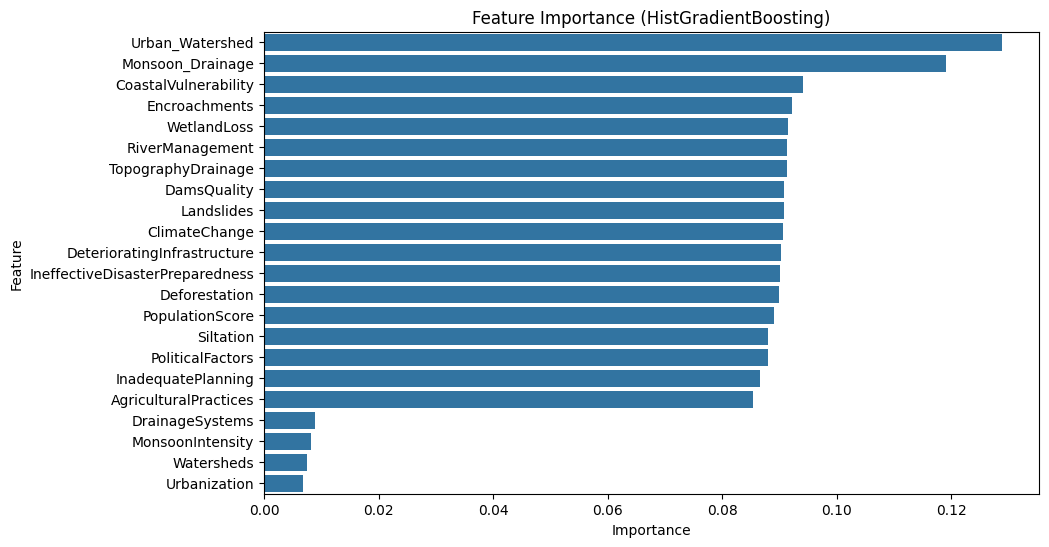

In [39]:
# Feature Importance
from sklearn.inspection import permutation_importance

result = permutation_importance(
    hgb_models["Single-core"], 
    X_test_scaled, 
    y_test,
    n_repeats=10,
    random_state=42
)

feature_importance = pd.DataFrame({
    'Feature': features,
    'Importance': result.importances_mean
}).sort_values('Importance', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importance)
plt.title('Feature Importance (HistGradientBoosting)')
plt.show()

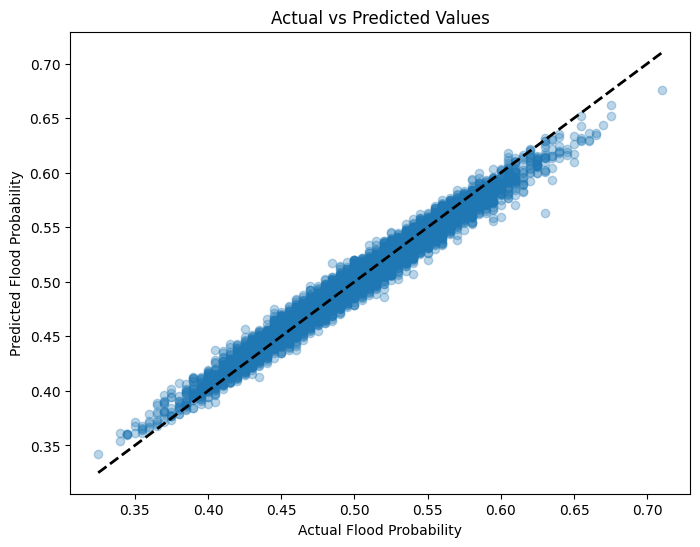

In [40]:
# Actual vs Predicted Plot
plt.figure(figsize=(8, 6))
plt.scatter(y_test, hgb_models["Single-core"].predict(X_test_scaled), alpha=0.3)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)
plt.xlabel('Actual Flood Probability')
plt.ylabel('Predicted Flood Probability')
plt.title('Actual vs Predicted Values')
plt.show()

In [41]:
# Prediction and Warning System
def flood_warning_system(input_data, model = hgb_models["Single-core"]):
    input_df = pd.DataFrame([input_data], columns=features)
    scaled_data = scaler.transform(input_df)
    proba = model.predict(scaled_data)[0]
    thresholds = {
        'green': 0.4,
        'yellow': 0.65,
        'orange': 0.85,
        'red': 1.0
    }
    if proba < thresholds['green']:
        level = "Normal"
        color = "green"
        action = "No action needed"
    elif proba < thresholds['yellow']:
        level = "Watch"
        color = "yellow"
        action = "Monitor weather updates"
    elif proba < thresholds['orange']:
        level = "Warning"
        color = "orange"
        action = "Prepare emergency supplies"
    else:
        level = "Emergency"
        color = "red"
        action = "Evacuate if in flood-prone area"
    explanation = []
    for i, feature in enumerate(features):
        value = input_data[i]
        if value > df[feature].quantile(0.9):
            explanation.append(f"High {feature} ({value})")
    return {
        'probability': float(proba),
        'warning_level': level,
        'color_code': color,
        'recommended_action': action,
        'key_factors': explanation,
        'threshold_breaches': [f for f in features 
                              if (input_data[features.index(f)] > df[f].quantile(0.9))]
    }

In [42]:
# Test Cases (each must have 22 values)
test_cases = [
    [2, 5, 4, 1, 3, 2, 4, 3, 2, 1, 3, 5, 1, 1, 4, 3, 2, 1, 2, 3, 6, 3],
    [6, 7, 6, 5, 6, 5, 7, 4, 5, 4, 7, 2, 4, 3, 6, 5, 6, 4, 5, 6, 12, 18],
    [9, 9, 8, 7, 8, 7, 9, 1, 7, 6, 9, 1, 7, 6, 8, 7, 8, 6, 7, 8, 72, 48]
]

In [43]:
for case in test_cases:
    result = flood_warning_system(case)
    print("\n" + "="*50)
    print(f"Input: {case}")
    print(f"Flood Probability: {result['probability']:.1%}")
    print(f"Warning Level: {result['warning_level']} ({result['color_code']})")
    print(f"Key Factors: {', '.join(result['key_factors'])}")
    print(f"Action: {result['recommended_action']}")


Input: [2, 5, 4, 1, 3, 2, 4, 3, 2, 1, 3, 5, 1, 1, 4, 3, 2, 1, 2, 3, 6, 3]
Flood Probability: 28.8%
Warning Level: Normal (green)
Key Factors: 
Action: No action needed

Input: [6, 7, 6, 5, 6, 5, 7, 4, 5, 4, 7, 2, 4, 3, 6, 5, 6, 4, 5, 6, 12, 18]
Flood Probability: 49.5%
Warning Level: Watch (yellow)
Key Factors: 
Action: Monitor weather updates

Input: [9, 9, 8, 7, 8, 7, 9, 1, 7, 6, 9, 1, 7, 6, 8, 7, 8, 6, 7, 8, 72, 48]
Flood Probability: 67.8%
Warning Level: Warning (orange)
Key Factors: High MonsoonIntensity (9), High TopographyDrainage (9), High DamsQuality (9), High IneffectiveDisasterPreparedness (9), High Monsoon_Drainage (72)
Action: Prepare emergency supplies


In [44]:
# Example test case
test_case = [2, 5, 4, 1, 3, 2, 4, 3, 2, 1, 3, 5, 1, 1, 4, 3, 2, 1, 2, 3, 6, 3]
result = flood_warning_system(test_case)
print(result)

{'probability': 0.28844837018225955, 'warning_level': 'Normal', 'color_code': 'green', 'recommended_action': 'No action needed', 'key_factors': [], 'threshold_breaches': []}


In [45]:
# Save the model pipeline
pipeline = {
    'model': hgb_models["Single-core"],
    'scaler': scaler,
    'features': features,
    'thresholds': {
        'watch': 0.3,
        'warning': 0.6,
        'emergency': 0.8
    }
}
joblib.dump(pipeline, 'flood_warning_pipeline.pkl')

['flood_warning_pipeline.pkl']

In [46]:
# --- CLASSIFICATION MODEL COMPARISON (RandomForestClassifier only) ---
df['FloodClass'] = (df['FloodProbability'] >= 0.5).astype(int)
target_clf = 'FloodClass'
X_clf = df[features]
y_clf = df[target_clf]

In [47]:
X_train_clf, X_temp_clf, y_train_clf, y_temp_clf = train_test_split(
    X_clf, y_clf, test_size=0.3, random_state=42, stratify=y_clf)
X_val_clf, X_test_clf, y_val_clf, y_test_clf = train_test_split(
    X_temp_clf, y_temp_clf, test_size=0.5, random_state=42, stratify=y_temp_clf)

In [48]:
scaler_clf = StandardScaler()
X_train_clf_scaled = scaler_clf.fit_transform(X_train_clf)
X_val_clf_scaled = scaler_clf.transform(X_val_clf)
X_test_clf_scaled = scaler_clf.transform(X_test_clf)

In [49]:
# Single-core
print("\n--- Training RandomForestClassifier (single-core) ---")
start_time = time.time()
model_clf_single = RandomForestClassifier(
    n_estimators=150,
    max_depth=8,
    min_samples_split=5,
    random_state=42,
    n_jobs=1
)
model_clf_single.fit(X_train_clf_scaled, y_train_clf)
clf_single_time = time.time() - start_time
print(f"Single-core training time (classification): {clf_single_time:.2f} seconds")


--- Training RandomForestClassifier (single-core) ---
Single-core training time (classification): 3.33 seconds


In [50]:
# Multi-core
print("\n--- Training RandomForestClassifier (multi-core, parallel) ---")
start_time = time.time()
model_clf_parallel = RandomForestClassifier(
    n_estimators=150,
    max_depth=8,
    min_samples_split=5,
    random_state=42,
    n_jobs=-1
)
model_clf_parallel.fit(X_train_clf_scaled, y_train_clf)
clf_parallel_time = time.time() - start_time
print(f"Multi-core training time (classification): {clf_parallel_time:.2f} seconds")


--- Training RandomForestClassifier (multi-core, parallel) ---
Multi-core training time (classification): 0.82 seconds


In [51]:
def evaluate_classification(model, X, y, set_name):
    y_pred = model.predict(X)
    y_proba = model.predict_proba(X)[:, 1]
    print(f"\n{set_name} Classification Evaluation:")
    print(f"Accuracy: {accuracy_score(y, y_pred):.2f}")
    print(f"F1 Score: {f1_score(y, y_pred):.2f}")
    print(f"ROC AUC: {roc_auc_score(y, y_proba):.2f}")
    print("Classification Report:\n", classification_report(y, y_pred))
    print("Confusion Matrix:\n", confusion_matrix(y, y_pred))

In [52]:
print("\n--- Classification Model Performance (Single-core) ---")
evaluate_classification(model_clf_single, X_test_clf_scaled, y_test_clf, "Test (Single-core)")


--- Classification Model Performance (Single-core) ---

Test (Single-core) Classification Evaluation:
Accuracy: 0.82
F1 Score: 0.82
ROC AUC: 0.91
Classification Report:
               precision    recall  f1-score   support

           0       0.82      0.81      0.81      3673
           1       0.82      0.83      0.82      3827

    accuracy                           0.82      7500
   macro avg       0.82      0.82      0.82      7500
weighted avg       0.82      0.82      0.82      7500

Confusion Matrix:
 [[2964  709]
 [ 660 3167]]


In [53]:
print("\n--- Classification Model Performance (Multi-core) ---")
evaluate_classification(model_clf_parallel, X_test_clf_scaled, y_test_clf, "Test (Multi-core)")


--- Classification Model Performance (Multi-core) ---

Test (Multi-core) Classification Evaluation:
Accuracy: 0.82
F1 Score: 0.82
ROC AUC: 0.91
Classification Report:
               precision    recall  f1-score   support

           0       0.82      0.81      0.81      3673
           1       0.82      0.83      0.82      3827

    accuracy                           0.82      7500
   macro avg       0.82      0.82      0.82      7500
weighted avg       0.82      0.82      0.82      7500

Confusion Matrix:
 [[2964  709]
 [ 660 3167]]


In [54]:
# Confusion Matrix Visualization
def plot_confusion_matrix(model, X, y, set_name):
    y_pred = model.predict(X)
    cm = confusion_matrix(y, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=['No Flood', 'Flood'],
                yticklabels=['No Flood', 'Flood'])
    plt.title(f'{set_name} Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

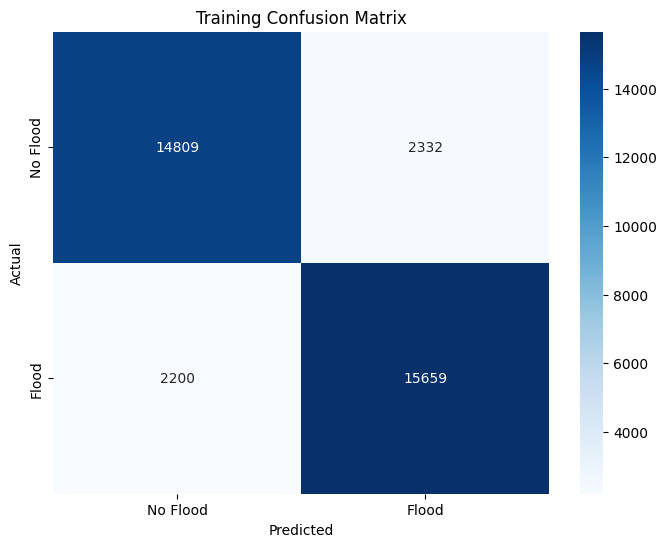

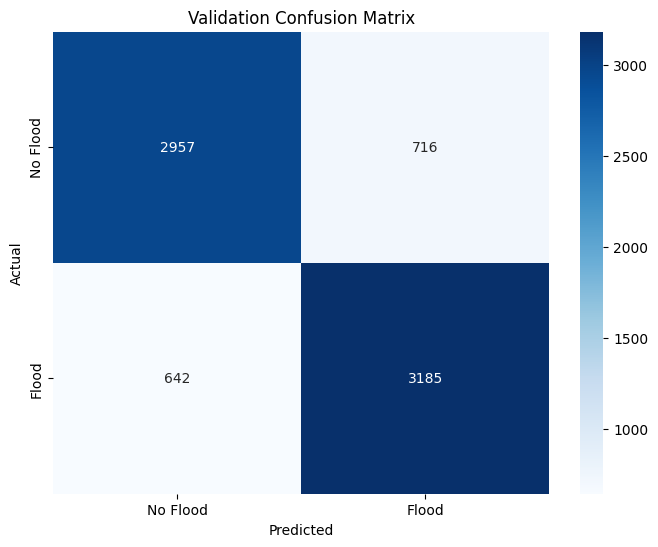

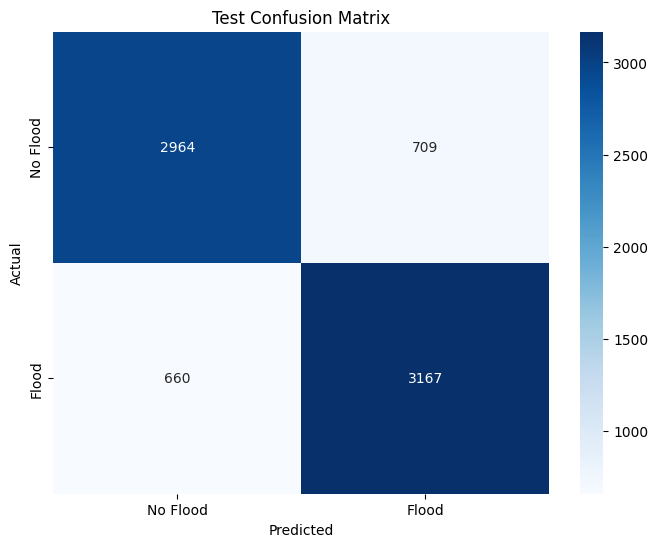

In [55]:
plot_confusion_matrix(model_clf_parallel, X_train_clf_scaled, y_train_clf, "Training")
plot_confusion_matrix(model_clf_parallel, X_val_clf_scaled, y_val_clf, "Validation")
plot_confusion_matrix(model_clf_parallel, X_test_clf_scaled, y_test_clf, "Test")